In [36]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from sklearn.metrics import mean_squared_error as MSE
import statsmodels.api as sm
import scipy
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

## Setting

In [241]:
def setting(n, p, p1, noise=1,npseed=0):
    np.random.seed(npseed)
    T=np.empty((n, p-p1))

    for i in range(n):
        T[i,:] = np.random.normal(0,1, size = (1, p-p1))

    beta1 = np.ones(p1)
    # beta2 = torch.cat((torch.ones(1), torch.zeros(p-p1-1)), dim=0)
    beta2 = np.ones(p-p1)
    # beta=np.concatenate((beta1,beta2),axis=0)
    # print
    Z = np.sin(T[:,0])+np.log1p(np.abs(T[:,1]))+1/(1+T[:,2])+np.maximum(T[:,3],0) +T[:,4]**2+ np.random.normal(0, noise, size = (n, ))
    Z=Z.reshape(n, 1)
    g_T = np.cosh(T[:,0])+T[:,1]+T[:,2]*T[:,3]
    g_T=g_T.reshape(n,1)
    y = np.matmul(Z,beta1).reshape(n, 1) + g_T + np.random.normal(0, noise, size = (n, 1))
    X = np.concatenate((Z, T), axis = 1)
    return y, X, beta1

def newset(y, Z, T):
    new_y = torch.tensor(np.concatenate((y, Z), axis=1)).float()
    new_data = torch.tensor(T).float()
    return new_y, new_data

## models

In [242]:
"""The :mod:`sklearn.kernel_regressor` module implements the Kernel Regressor.
"""
# Author: Jan Hendrik Metzen <janmetzen@mailbox.de>
#
# License: BSD 3 clause

import numpy as np

from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin


class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.

    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.

    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.

    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.

    See also
    --------

    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples, m]
            The target values

        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X_test):
        """Predict target values for X_test, size m*n_features.

        Parameters
        ----------
        X_test : array-like of shape = [n_te_samples, n_features]
            The input samples.

        Returns
        -------
        y : array of shape = [n_te_samples, m]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X_test, metric=self.kernel, gamma=self.gamma)
        # K.shape=[n_tr_samples, n_te_samples]
        # self.X.shape=[n_tr_samples, n_features]
        # self.y.shape=[n_tr_samples, m]
        if self.y.ndim==1:
            ncol=1
        else:
            ncol=self.y.shape[1]
        numerator=(np.transpose(self.y).dot(K)).reshape(ncol,K.shape[1])
        return np.transpose(numerator / K.sum(axis=0))

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]

In [243]:
def PLMNN(y_train, Z_train, T_train, y_test, Z_test, T_test):
  yZ_train, T_train = newset(y_train, Z_train, T_train)
  yZ_test, T_test = newset(y_test, Z_test, T_test)


  max_epoch = 50
  lr = 2e-4
  D_in, H, D_out = p-p1, 10000, p1+1
  batch_size = 512

  Train_dataset = TensorDataset(T_train, yZ_train)
  trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)
  Test_dataset = TensorDataset(T_test, yZ_test)
  testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size, shuffle=True)

  model = nn.Sequential(
      nn.Linear(D_in, H),
      nn.ReLU(),
      nn.Linear(H, D_out),
  )

  optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=2)
  criterion = nn.MSELoss()
  old_val_error=1e12
  patience=0

  start_time = time.time()
  for epoch in range(max_epoch):
    for batch_T, batch_yZ in trainloader:
      optimizer.zero_grad()
      batch_yZ_pred = model(batch_T)
      batch_loss = criterion(batch_yZ_pred, batch_yZ)
      #print(epoch+1, '---', batch_loss)
      batch_loss.backward()
      optimizer.step()
    with torch.no_grad():
      yZ_pred = model(T_test)
      val_loss = criterion(yZ_pred, yZ_test)
      print(epoch+1, '---', val_loss)

    #early stopping
    if val_loss.item()<old_val_error:
      old_val_error=val_loss.item()
      patience=0
    else:
      patience+=1
    if patience == 1:
      print('Break at epoch:', epoch)
      break

  model.eval()
  whole_pred=model(T_train).cpu().detach().numpy()
  mean_conditional_y_tr=whole_pred[:,0].reshape(-1,1)
  mean_conditional_Z_tr=whole_pred[:,1].reshape(-1,1)
  whole_pred_te=model(T_test).cpu().detach().numpy()
  mean_conditional_y_te=whole_pred_te[:,0].reshape(-1,1)
  mean_conditional_Z_te=whole_pred_te[:,1].reshape(-1,1)

  return mean_conditional_y_tr, mean_conditional_Z_tr,mean_conditional_y_te, mean_conditional_Z_te

In [244]:
def POAndInf(y_train, Z_train, T_train, y_val, Z_val, T_val, ml, cov_alpha=0.05):
  # np.random.seed(npseed)
  if ml == 'PLMNN':
    ml_pred_y, ml_pred_Z,ml_pred_y_val, ml_pred_Z_val = \
    PLMNN(y_train, Z_train, T_train, y_val, Z_val, T_val)

  else: 
    if ml == 'Kernel':
      ml_y = KernelRegression() 
      ml_Z = KernelRegression() 

    elif ml == 'Lasso':
      ml_y = Lasso(alpha = 1)  #
      ml_Z = Lasso(alpha = 1)  #, fit_intercept = False

    elif ml == 'Regression tree':
      ml_y = DecisionTreeRegressor(max_depth=2) #random_state=0
      ml_Z = DecisionTreeRegressor(max_depth=2) #random_state=0

    elif ml == 'Random forest':
      ml_y = RandomForestRegressor(max_depth=2) #max_depth=2, random_state=0,n_estimators=50
      ml_Z = RandomForestRegressor(max_depth=2) #max_depth=2, random_state=0,n_estimators=50

    else:
      print('Wrong ML name!')

    ml_y.fit(T_train, y_train)
    ml_pred_y = ml_y.predict(T_train).reshape(-1,1)  #T_test
    ml_pred_y_val = ml_y.predict(T_val).reshape(-1,1)  #T_test

    ml_Z.fit(T_train, Z_train)
    ml_pred_Z = ml_Z.predict(T_train).reshape(-1,1) #T_test
    ml_pred_Z_val = ml_Z.predict(T_val).reshape(-1,1) #T_test

  # plt.scatter(Z_train-ml_pred_Z,y_train-ml_pred_y);plt.show()
  # OLS
  ols_ml = sm.OLS(y_val-ml_pred_y_val, Z_val-ml_pred_Z_val).fit()
  cov_int = ols_ml.conf_int(alpha=cov_alpha,cols=None)[0]
  temp_beta = ols_ml.params
  temp_y_pred = (Z_train-ml_pred_Z).dot(temp_beta.reshape(-1,1))+ml_pred_y
  temp_y_pred_val = (Z_val-ml_pred_Z_val).dot(temp_beta.reshape(-1,1))+ml_pred_y_val
  # temp_y_pred = ols_ml.predict((Z_train-ml_pred_Z).flatten()).reshape(-1,1)+ml_pred_y
  # temp_y_pred_te = ols_ml.predict((Z_test-ml_pred_Z_val).flatten()).reshape(-1,1)+ml_pred_y_val
  temp_count=[(beta1<cov_int[1]) and (beta1>cov_int[0])]
  # plt.scatter(y_test.flatten(),temp_y_pred_val);plt.show()
  # print(ml,temp_beta,cov_int)
  return temp_beta, np.mean((temp_y_pred-y_train)**2),np.mean((temp_y_pred_val-y_val)**2), np.mean(temp_count)

## simulation

In [245]:
import warnings
warnings.filterwarnings("ignore")
Nrun, split_size, sigma, n, p, p1, kfold=10, 0.2, 1, 2000, 6, 1, 5
ymse_plm,ymse_plm_te, betamse_plm, cov_plm, time_plm = 0, 0, 0, 0, 0
ymse_nw,ymse_nw_te, betamse_nw, cov_nw, time_nw = 0, 0, 0, 0,0 # ymse is the mse of ytrain_pred, not ytest_pred
ymse_lasso,ymse_lasso_te, betamse_lasso, cov_lasso, time_lasso = 0, 0, 0, 0, 0
ymse_rt,ymse_rt_te, betamse_rt, cov_rt, time_rt = 0, 0, 0, 0, 0
ymse_rf,ymse_rf_te, betamse_rf, cov_rf, time_rf = 0, 0, 0, 0, 0
for i in range(Nrun):
  torch.manual_seed(i)
  np.random.seed(i)
  y, X, beta1 = setting(n=n, p=p, p1=p1, noise=sigma, npseed=i)

  # data spliting for non-kfold ml: PLMNN, Kernel
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42)
  Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
  Z_test, T_test = X_test[:, 0].reshape((-1,1)),  X_test[:, 1:]
  # PLMNN
  start_time = time.time()
  temp_beta_plm, temp_ymse_plm,temp_ymse_plm_te, temp_cov_plm = \
  POAndInf(y_train, Z_train, T_train, y_test, Z_test, T_test, ml='PLMNN')
  print(temp_beta_plm, temp_ymse_plm,temp_ymse_plm_te)
  ymse_plm += temp_ymse_plm/Nrun
  ymse_plm_te += temp_ymse_plm_te/Nrun
  betamse_plm += ((temp_beta_plm-beta1)**2)/Nrun
  cov_plm += temp_cov_plm/Nrun
  time_plm += (time.time() - start_time)/Nrun

  # Kernel
  start_time = time.time()
  temp_beta_nw, temp_ymse_nw,temp_ymse_nw_te, temp_cov_nw = \
  POAndInf(y_train, Z_train, T_train, y_test, Z_test, T_test, ml='Kernel')

  ymse_nw += temp_ymse_nw/Nrun
  ymse_nw_te += temp_ymse_nw_te/Nrun
  betamse_nw += ((temp_beta_nw-beta1)**2)/Nrun
  cov_nw += temp_cov_nw/Nrun
  time_nw += (time.time() - start_time)/Nrun

  # ml with kfold: Lasso, regression tree, random forest
  kf = KFold(n_splits=kfold)
  kfold_beta_lasso, kfold_ymse_lasso,kfold_ymse_lasso_te, kfold_cov_lasso = 0, 0, 0, 0
  kfold_beta_rt, kfold_ymse_rt,kfold_ymse_rt_te, kfold_cov_rt = 0, 0, 0, 0
  kfold_beta_rf, kfold_ymse_rf,kfold_ymse_rf_te, kfold_cov_rf = 0, 0, 0, 0


  for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
    Z_val, T_val = X_val[:, 0].reshape((-1,1)),  X_val[:, 1:]

    # Lasso
    start_time = time.time()
    temp_beta_lasso, temp_ymse_lasso,temp_ymse_lasso_te, temp_cov_lasso = \
    POAndInf(y_train, Z_train, T_train, y_val, Z_val, T_val, ml='Lasso')
    # print(np.mean((T_test.dot(temp_beta_lasso)-T_test.dot(beta1))**2))
    kfold_beta_lasso += temp_beta_lasso/kfold
    kfold_ymse_lasso += temp_ymse_lasso/kfold
    kfold_ymse_lasso_te += temp_ymse_lasso_te/kfold
    kfold_cov_lasso += temp_cov_lasso/kfold
    time_lasso += (time.time() - start_time)/kfold/Nrun

    # Regression tree
    start_time = time.time()
    temp_beta_rt, temp_ymse_rt,temp_ymse_rt_te, temp_cov_rt = \
    POAndInf(y_train, Z_train, T_train, y_val, Z_val, T_val, ml='Regression tree')

    kfold_beta_rt += temp_beta_rt/kfold
    kfold_ymse_rt += temp_ymse_rt/kfold
    kfold_ymse_rt_te += temp_ymse_rt_te/kfold
    kfold_cov_rt += temp_cov_rt/kfold
    time_rt += (time.time() - start_time)/kfold/Nrun

    # Random forest
    start_time = time.time()
    temp_beta_rf, temp_ymse_rf,temp_ymse_rf_te, temp_cov_rf = \
    POAndInf(y_train, Z_train, T_train, y_val, Z_val, T_val, ml='Random forest')

    kfold_beta_rf += temp_beta_rf/kfold
    kfold_ymse_rf += temp_ymse_rf/kfold
    kfold_ymse_rf_te += temp_ymse_rf_te/kfold
    kfold_cov_rf += temp_cov_rf/kfold
    time_rf += (time.time() - start_time)/kfold/Nrun

  ymse_lasso += kfold_ymse_lasso/Nrun
  ymse_lasso_te += kfold_ymse_lasso_te/Nrun
  betamse_lasso += ((kfold_beta_lasso-beta1)**2)/Nrun
  cov_lasso += kfold_cov_lasso/Nrun

  ymse_rt += kfold_ymse_rt/Nrun
  ymse_rt_te += kfold_ymse_rt_te/Nrun
  betamse_rt += ((kfold_beta_rt-beta1)**2)/Nrun
  cov_rt += kfold_cov_rt/Nrun

  ymse_rf += kfold_ymse_rf/Nrun
  ymse_rf_te += kfold_ymse_rf_te/Nrun
  betamse_rf += ((kfold_beta_rf-beta1)**2)/Nrun
  cov_rf += kfold_cov_rf/Nrun


1 --- tensor(242.8669)
2 --- tensor(238.6536)
3 --- tensor(238.0800)
4 --- tensor(238.5025)
Break at epoch: 3
[0.99578105] 3.553059857061435 3.0404686994924623
1 --- tensor(3292.6438)
2 --- tensor(3279.8982)
3 --- tensor(3270.2803)
4 --- tensor(3261.7424)
5 --- tensor(3256.0327)
6 --- tensor(3252.3857)
7 --- tensor(3250.2676)
8 --- tensor(3250.2180)
9 --- tensor(3250.7278)
Break at epoch: 8
[1.00017142] 3.5197046764918842 5.4249135817676155
1 --- tensor(1585.5413)
2 --- tensor(1580.1779)
3 --- tensor(1578.5431)
4 --- tensor(1578.3767)
5 --- tensor(1578.6394)
Break at epoch: 4
[0.99958549] 3.8626214140304547 3.3871388191962915
1 --- tensor(1733.3363)
2 --- tensor(1723.2806)
3 --- tensor(1720.1840)
4 --- tensor(1719.2993)
5 --- tensor(1720.1031)
Break at epoch: 4
[0.99855426] 3.5006148558895362 3.5977674222690994
1 --- tensor(1509.1234)
2 --- tensor(1510.0992)
Break at epoch: 1
[0.99520917] 5.525885890069957 5.1797174504711485
1 --- tensor(2914.4109)
2 --- tensor(2903.3657)
3 --- tensor(

## results

In [246]:
print(ymse_plm,ymse_plm_te, betamse_plm, cov_plm, time_plm)

3.8144470952757166 3.8672218865758055 [4.00449017e-05] 0.9999999999999999 1.8674884080886842


In [247]:
print(ymse_nw,ymse_nw_te, betamse_nw, cov_nw, time_nw)

3.507944462179913 3.658633977202838 [1.25968957e-05] 0.9999999999999999 0.16477375030517577


In [248]:
print(ymse_lasso,ymse_lasso_te, betamse_lasso, cov_lasso, time_lasso)

4.174117494326354 3.992984711317373 [3.78152809e-06] 0.9399999999999998 0.0029456233978271485


In [249]:
print(ymse_rt,ymse_rt_te, betamse_rt, cov_rt, time_rt)

8.414358692868948 15.506466105535937 [0.00240019] 0.8399999999999999 0.003319854736328125


In [250]:
print(ymse_rf,ymse_rf_te, betamse_rf, cov_rf, time_rf)

88.54319162368355 19.6809601722874 [0.00054338] 0.19999999999999996 0.4473811769485472


# NTK converges exponentially fast

In [251]:
n=100
torch.manual_seed(0)
np.random.seed(0)
y_train, X_train, beta1 = setting(n=n, p=p, p1=p1, noise=sigma)
Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
from sklearn import preprocessing
T_train=preprocessing.normalize(T_train, norm='l2')
yZ_train, T_train = newset(y_train, Z_train, T_train)


max_epoch = 5000
lr = 1e-2
D_in, H, D_out = p-p1, 10000, p1+1
batch_size = n

Train_dataset = TensorDataset(T_train, yZ_train)
trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()
y_loss,Z_loss=[],[]
for epoch in range(max_epoch):
  for batch_T, batch_yZ in trainloader:
    optimizer.zero_grad()
    batch_yZ_pred = model(batch_T)
    batch_loss = criterion(batch_yZ_pred, batch_yZ)
    batch_loss.backward()
    optimizer.step()
  with torch.no_grad():
    yZ_pred = model(T_train).cpu().detach().numpy()
    print(epoch,np.mean((yZ_pred[:,0]-y_train.flatten())**2),np.mean((yZ_pred[:,1]-Z_train.flatten())**2))
    y_loss.append(np.mean((yZ_pred[:,0]-y_train.flatten())**2))
    Z_loss.append(np.mean((yZ_pred[:,1]-Z_train.flatten())**2))

0 203.8505889907127 90.80153208481106
1 1673.954990855814 699.626900166877
2 13452.537551255116 5576.70594846693
3 39710.70491583539 16450.440185486135
4 171.63315894949037 75.2384726874526
5 135.36113432211317 60.574856781852816
6 110.15461753734236 50.40320180739711
7 91.8762896877978 43.0400312162211
8 78.17993207756574 37.53158055500847
9 67.65545323145832 33.30596665588222
10 59.40055326379802 29.99708085422846
11 52.82037766527742 27.36382760369788
12 47.502601764454155 25.23925299650528
13 43.15134065254541 23.503612751991408
14 39.55530621087331 22.071678223867465
15 36.556679479748865 20.879650063112795
16 34.03669722054691 19.879533771759302
17 31.904292683872164 19.034450183143715
18 30.086728662036027 18.315186698208528
19 28.528316094774333 17.699327030554226
20 27.18596077854621 17.169555856369556
21 26.024037188039816 16.711486160522607
22 25.01305706701356 16.31320056629901
23 24.130589469828656 15.965743809677422
24 23.356392371540718 15.661075765297813
25 22.674087434

204 12.10600760905444 10.466109954886765
205 12.091527751574532 10.456751778902825
206 12.077133315503302 10.447452050566158
207 12.062809172992194 10.43819770014329
208 12.048595885047714 10.428968717915131
209 12.034391869707834 10.419753835160087
210 12.02028288600128 10.410606095066704
211 12.00626700510563 10.401486285441676
212 11.99231002303556 10.392421882672913
213 11.978429402358778 10.383384208555695
214 11.964558576848688 10.374356081115836
215 11.950829152001095 10.365416374645497
216 11.937114336114389 10.356466104065124
217 11.92349363132282 10.347591275772846
218 11.90995244684297 10.338741201756658
219 11.896446034492591 10.329909023899681
220 11.883068795580934 10.32114254495102
221 11.869704735686382 10.312410352937587
222 11.856424570007926 10.303681106669666
223 11.843237019356929 10.295041075124221
224 11.830076394094215 10.286389476086388
225 11.817034807110062 10.277822376052372
226 11.803974709824622 10.269241962740727
227 11.791057025928092 10.260728695829188


413 10.049366247009868 9.037979020011027
414 10.042179301054063 9.03265753813519
415 10.035039266951522 9.027344061813146
416 10.027938828172122 9.02205818235685
417 10.020697197801347 9.016663662154041
418 10.013645832617183 9.011414662945516
419 10.006564615127163 9.006137024455311
420 9.999441123250447 9.000830253952433
421 9.992367801223308 8.995560762421032
422 9.985308638557624 8.990314224799349
423 9.978296366678238 8.985063889299582
424 9.971217283366633 8.979780280525636
425 9.964221306280352 8.974591239410751
426 9.957187162388028 8.969298006995754
427 9.950263151351123 8.964173234063637
428 9.943309237762957 8.958964808789169
429 9.936220744478247 8.953664643582934
430 9.929387404579437 8.948567831436984
431 9.922390937004236 8.943337821561585
432 9.915484782965796 8.938179575019943
433 9.90849630709823 8.932961730664571
434 9.901630223441854 8.927813585446136
435 9.894757453445997 8.922686551749313
436 9.887844418116927 8.917480969725935
437 9.880993393311616 8.912360829531

623 8.751331974830116 8.039160656070246
624 8.746054591886535 8.034988136404538
625 8.740428677263282 8.030475518304645
626 8.735207945211476 8.02631275123637
627 8.729651479566941 8.0218899615572
628 8.724373108121291 8.017656852154426
629 8.718894413222811 8.013314159312944
630 8.713468480713022 8.008939510237495
631 8.708081295691276 8.004704407667145
632 8.70266819969165 8.000391778931508
633 8.697400956317383 7.996144495746632
634 8.691821340435226 7.991710439885776
635 8.686610962427988 7.9875417929356285
636 8.681178647525389 7.98321771772479
637 8.675844625688322 7.978963358540986
638 8.670511994191775 7.974676256474048
639 8.665082707963968 7.970362141846778
640 8.659837141747593 7.9661563555969375
641 8.654345584918033 7.961796934432748
642 8.649214569045501 7.957662140377288
643 8.643755353600985 7.953266682902401
644 8.638480290377224 7.949083444082504
645 8.633177713154874 7.944854998058832
646 8.627811393031772 7.940511481203652
647 8.622481196395166 7.936238787165613
648

832 7.706372821971654 7.186937018719591
833 7.701862966077368 7.183168446219888
834 7.697136520890141 7.179246568807278
835 7.692523903378443 7.175373207789165
836 7.688028670527433 7.171619544548148
837 7.683332154326354 7.16772046526896
838 7.678872018742531 7.163983582572457
839 7.674131100914921 7.16000556552433
840 7.66966385800834 7.156285949718437
841 7.66507301356093 7.152445117394506
842 7.660602592153115 7.148683050012662
843 7.65594584705255 7.144831523298209
844 7.651364752757387 7.140940389353862
845 7.646820585789194 7.137186982718442
846 7.642225171465608 7.133319559776285
847 7.63776936600403 7.129612274249817
848 7.633171214873184 7.125747677453599
849 7.628610673949286 7.121902595450354
850 7.62391685988517 7.118006296186223
851 7.619656002505962 7.114429803737154
852 7.615005551897202 7.110512681892001
853 7.610312852371547 7.106578162365938
854 7.605977839451095 7.1029208383307125
855 7.601282412054166 7.099026983406223
856 7.596742420235464 7.095202217368257
857 7.

1044 6.790622467721455 6.407403642025659
1045 6.786381706231463 6.403745856081511
1046 6.782271621375354 6.400138618087507
1047 6.778269630473834 6.396735404479125
1048 6.774049936018597 6.393044684959107
1049 6.770005243813333 6.389490820250712
1050 6.765996872442422 6.386028979753609
1051 6.761787722801107 6.382396259868952
1052 6.757687791493717 6.378817458398011
1053 6.753726317608223 6.375303584870874
1054 6.7495203816304015 6.371674562898392
1055 6.745514921406815 6.3681760401233545
1056 6.741416754140337 6.364634794608089
1057 6.7372332721497195 6.361010854729784
1058 6.73330845991288 6.357568189039541
1059 6.72905643071495 6.353895856341087
1060 6.725042176052031 6.3503596158746545
1061 6.720975287600555 6.346826636006308
1062 6.717006607689719 6.3434283271399305
1063 6.7127357814585515 6.339584760146594
1064 6.708821943528375 6.336194543769195
1065 6.704622599371817 6.3326162188018245
1066 6.700737538899915 6.329186943828859
1067 6.6965082126948445 6.32548794491261
1068 6.6927

1247 6.002722597496055 5.712199591286311
1248 5.999050178327373 5.70879564182349
1249 5.995313209453392 5.705609762518071
1250 5.991427218354764 5.70208343866132
1251 5.988063975765181 5.699054893693187
1252 5.984162925832232 5.695626773181527
1253 5.980562155213083 5.692441243036343
1254 5.976971421492426 5.6892137290936935
1255 5.973081730657227 5.685726622283563
1256 5.969790892259328 5.682744944637983
1257 5.9658346783027385 5.679301142362714
1258 5.962368580634543 5.67617270489216
1259 5.958540996761408 5.672765511537323
1260 5.9549171808556105 5.66954000358015
1261 5.951502786765791 5.666484508162191
1262 5.947708919825918 5.66306984641797
1263 5.944072250982134 5.659829184729151
1264 5.940326113293323 5.656511660153711
1265 5.93672712247251 5.653349397894065
1266 5.933034796939735 5.6499601402672734
1267 5.929568913933532 5.646916766288674
1268 5.925725577295164 5.643479182326781
1269 5.922198211703642 5.640310985143965
1270 5.918618150624132 5.637103478769718
1271 5.91486316417

1453 5.283699973297981 5.0658597915623735
1454 5.280860976523927 5.063188714623751
1455 5.2772720092823215 5.0600225072680125
1456 5.273929565273321 5.056965600361434
1457 5.270578827382086 5.053942534120653
1458 5.26720497110898 5.050952468852817
1459 5.264249508512539 5.048165217674964
1460 5.2606055774935045 5.044929295475833
1461 5.257434305722752 5.042029014933672
1462 5.25411036095966 5.039024423317529
1463 5.250765992678945 5.035968818477175
1464 5.2475351347872 5.033070448948199
1465 5.244181787949209 5.030039472364782
1466 5.240687702678729 5.026874145212149
1467 5.237697829082355 5.024095355738619
1468 5.2342948857391 5.020967206445914
1469 5.230984847775574 5.018057985803543
1470 5.227570708700118 5.015053285292399
1471 5.224518203034455 5.012107136874668
1472 5.220991913435151 5.0090073833886315
1473 5.2177825817699555 5.006043291475475
1474 5.214587575096448 5.003110486971143
1475 5.211198936799242 5.000056475267931
1476 5.207917210062443 4.997082740507887
1477 5.204752570

1653 4.646070750968359 4.485457523903206
1654 4.642965493050496 4.48258712533484
1655 4.64027649808503 4.480126248804989
1656 4.636907479022707 4.47706290138592
1657 4.633852103884758 4.474309732462253
1658 4.630891905317346 4.471631468042409
1659 4.627804434339291 4.468685753984926
1660 4.625059798286834 4.466201210221837
1661 4.621624248625963 4.4630674341501
1662 4.618779037770807 4.460413863493261
1663 4.61577322443325 4.457689263831296
1664 4.612622755752017 4.4548377754076185
1665 4.609585370491184 4.452018989608742
1666 4.606756527015151 4.449387827516831
1667 4.603297099762051 4.446211697993412
1668 4.600847820966743 4.444057509865976
1669 4.597454685436898 4.440914948120818
1670 4.594457977748288 4.438120152002878
1671 4.591399814602558 4.435368229819363
1672 4.588494722589359 4.432677384727539
1673 4.585347374510103 4.429803543815374
1674 4.582409637695646 4.427071319055006
1675 4.579590999689647 4.424437046314365
1676 4.576046124636461 4.421321623679174
1677 4.57345856421741

1853 4.06503078603913 3.9495096456945054
1854 4.062631678581302 3.947165837573092
1855 4.059507743620854 3.9443086078876983
1856 4.05686362241536 3.941940593681578
1857 4.054315864295868 3.939528309600886
1858 4.0514585717565 3.936826410748443
1859 4.048473697198704 3.934132087928369
1860 4.045998235719581 3.93182787828866
1861 4.043322911649078 3.9292682095938587
1862 4.040301274673881 3.9265686458683153
1863 4.037577424410838 3.92392454349754
1864 4.034898046078677 3.921538928062487
1865 4.03206750476492 3.91888334224751
1866 4.029472635014384 3.916420597163572
1867 4.0268471162995265 3.9139789952162425
1868 4.023692147688505 3.911120125556106
1869 4.021135721405543 3.908757378371917
1870 4.018417965417503 3.906193036461837
1871 4.015708996473313 3.9036007439006717
1872 4.013069405802039 3.9012444709180305
1873 4.010163304552558 3.8984163250686894
1874 4.007557532403318 3.896113036740803
1875 4.004451340222642 3.8932509241845015
1876 4.002230198266235 3.891143337897661
1877 3.9992030

2051 3.548310221147405 3.4658155083045874
2052 3.5460136110501366 3.463547249535084
2053 3.5433389867126017 3.461121725421263
2054 3.5411061700320774 3.4589001634252843
2055 3.5385236546395675 3.456511857132519
2056 3.5359841266062557 3.4540707296041457
2057 3.533696049082362 3.4520640534584435
2058 3.5311025111485175 3.4494434758946952
2059 3.5287811046722988 3.447314598172637
2060 3.5261880107527217 3.4448900187268117
2061 3.523862186002042 3.4425934166665244
2062 3.5214669272562897 3.4403807994048448
2063 3.518922179190586 3.437987894139976
2064 3.5164195387026886 3.4356654570664062
2065 3.5141364431357283 3.4334953922969924
2066 3.5115500859416047 3.43100455509643
2067 3.5091211532901747 3.4287340354581435
2068 3.506734223006516 3.4265103109251425
2069 3.5043020444027557 3.424171722846517
2070 3.5017488339794034 3.4218102502448433
2071 3.499391685197112 3.4195772364827572
2072 3.4969814293344097 3.4172587932042298
2073 3.494489727043479 3.414900023636081
2074 3.4921675923108886 3.4

2253 3.0815409560930225 3.023176466738503
2254 3.079310168705961 3.021049864440605
2255 3.0769764943098097 3.018759080217744
2256 3.0751001653537458 3.0170894146411444
2257 3.072655922340808 3.01472517359416
2258 3.070514205967239 3.0126868154965423
2259 3.068205473804659 3.0104802256338035
2260 3.0664426627491626 3.0087619178541076
2261 3.063884242165579 3.0063280237981163
2262 3.0617585376017407 3.0043549403390704
2263 3.0597198899609013 3.002414162570399
2264 3.0574737836455004 3.0002880172329496
2265 3.0553264968336036 2.998197145936657
2266 3.053102035184146 2.996136568728817
2267 3.050903306591041 2.993968767044407
2268 3.048766596445518 2.992010598340303
2269 3.046725781780493 2.990000568806179
2270 3.0444210594830845 2.9878446187903864
2271 3.0421873794763084 2.9857287525245026
2272 3.040170085790689 2.983769129704407
2273 3.0379924393460898 2.981708852642658
2274 3.036008577173543 2.979811821383565
2275 3.0334867773754075 2.9774684869971484
2276 3.0315371573217673 2.9755634101

2453 2.6678870415120857 2.628287369653611
2454 2.665817601998403 2.626420260359102
2455 2.663792085721417 2.6244356710000005
2456 2.6620622834479986 2.6226845641454015
2457 2.6599094302801944 2.620753761938829
2458 2.658025980362633 2.6189228997756775
2459 2.6560268306030856 2.61693738625519
2460 2.654277053153404 2.615295613603522
2461 2.652133474895012 2.6132637223712516
2462 2.650306588201269 2.6115151970052297
2463 2.6482561318366744 2.6095327965620965
2464 2.6464434480083123 2.607831293874175
2465 2.644424792697089 2.6058251973626625
2466 2.642393088521166 2.6038447041479578
2467 2.6406663964609174 2.60231096661368
2468 2.6387137870723927 2.6003412311291982
2469 2.636667615123094 2.5984859543272716
2470 2.634788988257626 2.596575011876664
2471 2.632953715280666 2.594882114645733
2472 2.6307834270093826 2.5928096450562337
2473 2.628991035760578 2.591156774837086
2474 2.6270815764222704 2.589165473119209
2475 2.625358461315734 2.587501065377566
2476 2.6230023269358727 2.585370381052

2652 2.3046070946805406 2.2791434970229862
2653 2.3029911889123453 2.2776605910499508
2654 2.301034899312766 2.2757274806417076
2655 2.299745247676191 2.2744760643818154
2656 2.2977970816379196 2.2725635181667103
2657 2.2961489544439466 2.2709692349432005
2658 2.294440251071513 2.2693166514839063
2659 2.292724215406665 2.267727824254652
2660 2.2909067192862285 2.2659830615933383
2661 2.289224421302365 2.2642521162070075
2662 2.287698024353697 2.2628707546389526
2663 2.285690365020029 2.2608606197867034
2664 2.284316787045881 2.2595751461828204
2665 2.282524259475335 2.2578031017347526
2666 2.2805087900789696 2.2559311189231717
2667 2.2791579127392034 2.25461400408882
2668 2.2774723833142763 2.2529161393085007
2669 2.275526806432336 2.251112657389393
2670 2.2739434272858903 2.2496566787790724
2671 2.2722930741739265 2.247948220906423
2672 2.270541107891043 2.2463567439752676
2673 2.2689150360223524 2.244712601079533
2674 2.26722030001744 2.243089600892818
2675 2.265584132775852 2.241421

2851 1.9849772748569618 1.9700067637648302
2852 1.9835660759551517 1.9685474793691387
2853 1.9819580878701017 1.9670856600860511
2854 1.9805663925497703 1.965696616867159
2855 1.979147283847842 1.964290506091361
2856 1.9774112515169469 1.9627082763163946
2857 1.9759822263864555 1.9611718271241134
2858 1.9747425023031802 1.9601043274669545
2859 1.9728205015079954 1.9581449483383526
2860 1.9716952142227555 1.9570922759626805
2861 1.9701903855846328 1.9555821625546388
2862 1.9685043980441348 1.9540479391256653
2863 1.9671523439308765 1.9527217734318922
2864 1.9655877165432512 1.9511729533582391
2865 1.964272567087413 1.9498501471704852
2866 1.9626832021858738 1.9483883588416813
2867 1.961320533431954 1.9469369567076924
2868 1.9597851439696654 1.9456194539492833
2869 1.95813901437835 1.9438535854314094
2870 1.9569147624347745 1.9427891784359252
2871 1.9552275678156277 1.9411297710351318
2872 1.9539133686904662 1.9397558048525871
2873 1.952187661978908 1.9382162337486872
2874 1.951078836092

3045 1.7142398954240938 1.706697647166702
3046 1.713032493335096 1.7056211092984892
3047 1.7118046350422198 1.7042118965015174
3048 1.7104710040245608 1.703007706420392
3049 1.709134277356802 1.7016492409177624
3050 1.7077197842534984 1.700440091280821
3051 1.7064510743944659 1.6990669052946707
3052 1.7053224710585007 1.6980273303460758
3053 1.7039803463303074 1.6965981445741185
3054 1.702517206376887 1.6952651517925121
3055 1.7013108896156481 1.6941208977259554
3056 1.700009781877709 1.6927913603445497
3057 1.6988027231709089 1.6915906870609254
3058 1.6974957350627955 1.6903122032972615
3059 1.6961069099869903 1.6890077064569393
3060 1.6948390985806217 1.6877362190690934
3061 1.693504801058226 1.6864581615403238
3062 1.6922954714507639 1.6852178328537994
3063 1.690770765826927 1.683866170223835
3064 1.68989431955685 1.6829111263871115
3065 1.6882463753469295 1.6813484962481267
3066 1.6873055479101566 1.6803356242022012
3067 1.6858441769375694 1.6789833099268054
3068 1.684468144680966 

3243 1.4737486024133362 1.4713472126274894
3244 1.472728651688917 1.4703442272524174
3245 1.47165318743684 1.4692329240925162
3246 1.470369030140422 1.4680418681302125
3247 1.4694915232477865 1.467070196965617
3248 1.468103077426501 1.4658101786056834
3249 1.4670782360937893 1.464802225795192
3250 1.4658903792800337 1.4636797112687074
3251 1.4649374625646172 1.4626755757098377
3252 1.4635659690449878 1.4614464797505662
3253 1.4627840623675812 1.4605594845892784
3254 1.4613769357135749 1.4591980973789793
3255 1.4604614026544924 1.4583172321148488
3256 1.4591979220750841 1.457061175725082
3257 1.4581713312759006 1.456034189440692
3258 1.457061026278885 1.4549655881697239
3259 1.4558135170481519 1.4537277194597331
3260 1.4548119947745597 1.4528017338600783
3261 1.4536149577175537 1.4516484492878912
3262 1.4526921956705054 1.4506228964015744
3263 1.451374755202986 1.44945353445812
3264 1.4503134522995864 1.4483788849654378
3265 1.4492612907713383 1.4473784135886205
3266 1.4480413329130744 

3437 1.270017150323915 1.2715618782320945
3438 1.2688938295825976 1.2703189336427796
3439 1.2680200477112784 1.26962674101122
3440 1.2668461202840888 1.2684699357085887
3441 1.2661599109267432 1.2676869290820232
3442 1.2650059554603308 1.2665712226354087
3443 1.2640401655643658 1.2656186380100345
3444 1.2631716966352926 1.2647462079985123
3445 1.2621882100508466 1.2637980043534185
3446 1.2612674267914274 1.2629208381770052
3447 1.2600467652170804 1.26168181456543
3448 1.2593914078866517 1.2610475726482546
3449 1.2582584686586427 1.2599292531741377
3450 1.257282940736505 1.2589672077141139
3451 1.2564699730988316 1.2580944995957153
3452 1.2553994461872022 1.2570989473747745
3453 1.2543611577952918 1.256127141977101
3454 1.2534845721129277 1.255209532644897
3455 1.2526573218983459 1.2543692641434325
3456 1.25131214601366 1.2531602020223873
3457 1.2507943652109688 1.2525579437613084
3458 1.249622444019899 1.251399903637324
3459 1.248697385113872 1.2505454383376813
3460 1.2477009465188948 

3641 1.0865444114010332 1.0905134893680375
3642 1.085528577374473 1.0895875551606933
3643 1.0846987102776522 1.0887380805818305
3644 1.0839754591975577 1.088059033689711
3645 1.08315807574077 1.087228675904573
3646 1.0822984088892251 1.0863948740580696
3647 1.081442274523229 1.085565683990789
3648 1.0806477323393215 1.084842172584455
3649 1.0798664072007857 1.0839341025073208
3650 1.0790172551992752 1.0831233750678388
3651 1.078100414056976 1.0822512963625222
3652 1.0773344063216053 1.081451523346801
3653 1.0766002409443136 1.0807677118904206
3654 1.0756762266066309 1.0798563459318438
3655 1.0750588625249986 1.0792039857969726
3656 1.0739694377675648 1.0781761570432946
3657 1.0732831162352767 1.0774801679826294
3658 1.0725659825499019 1.0767164256689474
3659 1.0714474423569225 1.0756581184762621
3660 1.0708870649034257 1.075076887225836
3661 1.0699053595062802 1.0741254759440133
3662 1.069286294783889 1.07353943153485
3663 1.0681941809101003 1.0724821767010189
3664 1.0676378655390137 1

3840 0.9330094079381689 0.9386565161722463
3841 0.9322654848816608 0.9379372497371239
3842 0.9314823199785134 0.9371666263509385
3843 0.9308572635982293 0.936570702675426
3844 0.9301038057077692 0.9358436509841291
3845 0.9293508591134314 0.9351447626113186
3846 0.9287639199773315 0.9344428685854115
3847 0.9280332823616483 0.9337771622986696
3848 0.9271238003754594 0.932929357365163
3849 0.9265214265017012 0.9322496585597868
3850 0.9259074367363296 0.9316926433461287
3851 0.9251636628487598 0.9309112645316797
3852 0.9243512380129845 0.9301300469832188
3853 0.923623821633341 0.9294437354727981
3854 0.9230765856744175 0.9288612459963717
3855 0.9222249633952692 0.9280376032107095
3856 0.9216270878963145 0.9274570936715064
3857 0.9209455555411218 0.9267684145086287
3858 0.9200804159060744 0.9259628984939865
3859 0.9195424090676778 0.9254027561505932
3860 0.9187849110971612 0.9246569013621573
3861 0.9180714755253122 0.9238863041525915
3862 0.9173465178816095 0.9232900831816857
3863 0.9165418

4039 0.800925656876973 0.8080844423526001
4040 0.8001576326891857 0.8073787510568121
4041 0.799713457517181 0.8069586898554882
4042 0.7990087267517572 0.8062578876491362
4043 0.7984276477470492 0.8055933975019302
4044 0.7977653284354357 0.8050618600692063
4045 0.797225026847192 0.80445763154683
4046 0.7965261026204886 0.803782201839692
4047 0.7960034991097185 0.8032776298535984
4048 0.7953950134617835 0.8026162330799237
4049 0.7947066145925527 0.8019992156302377
4050 0.7941391001009279 0.8014144657529121
4051 0.7935677783598443 0.8008260952402461
4052 0.7928856099461212 0.8002281018325315
4053 0.792298805654986 0.7995838029025809
4054 0.7917692350457943 0.7990583764091334
4055 0.7910139741391085 0.7983892742929206
4056 0.7904868876737159 0.7978156559148651
4057 0.7898465676729949 0.7972163449640307
4058 0.7892953741729761 0.7965945548043597
4059 0.7886336175563007 0.7959939408344907
4060 0.7880414483285882 0.795381887336694
4061 0.7874473122411662 0.7948048178553481
4062 0.786829996263

4239 0.6868825470285447 0.6952560372712208
4240 0.6863239695083027 0.6947273430279499
4241 0.6857951863401774 0.6942048561733065
4242 0.6853997834498575 0.6937490524308343
4243 0.6847484253512617 0.6931822996872722
4244 0.6842748865338909 0.6926906919205108
4245 0.6837783996825846 0.6922239941727009
4246 0.6831879091946061 0.6915509428501865
4247 0.6827104257018258 0.6911530529939103
4248 0.6821307704502787 0.6905992025068163
4249 0.681713339666101 0.690034808905804
4250 0.6810521446271904 0.6895450271842681
4251 0.6805920705553125 0.6890750267630044
4252 0.6801148389999362 0.6885465218827417
4253 0.6795296440974312 0.6879658373136524
4254 0.6790692068895006 0.6875758831801905
4255 0.6784369478177171 0.6868930945598366
4256 0.6780012797563769 0.6864387863483128
4257 0.6775322397995052 0.6860406255182383
4258 0.676837570427601 0.6853199223855618
4259 0.676501478881402 0.6849990426455587
4260 0.6759009268737773 0.6843613986094127
4261 0.675391354737755 0.6839147261888324
4262 0.674898887

4437 0.5900892061831626 0.5991097504504829
4438 0.5895182784094197 0.5985763651614727
4439 0.5891178936792272 0.5981585068151836
4440 0.5886738138023029 0.5977343580136091
4441 0.5882500938399935 0.5972573795090581
4442 0.5877338592331666 0.5968134766766459
4443 0.5873750638650788 0.5964022624236729
4444 0.5868102914486668 0.5958603233754514
4445 0.586432304242721 0.5954890999258466
4446 0.5860068261446589 0.5950561596091408
4447 0.5854611056402184 0.5945054729010883
4448 0.5850822164876824 0.5941833584852396
4449 0.5845728163371429 0.5936316453514924
4450 0.5842304314157477 0.5932631402914589
4451 0.5837193731811661 0.5927639803012742
4452 0.5832268415408766 0.5923173674730163
4453 0.5828411606625243 0.5919280068614341
4454 0.5823628365266535 0.5914294798877815
4455 0.5819339340881254 0.5910327888652456
4456 0.581434048858193 0.5905275125660729
4457 0.5810899657497859 0.5901398517578492
4458 0.580567002795143 0.5896772602625316
4459 0.5801231496245114 0.5892011001572194
4460 0.5796966

4634 0.5071630318009922 0.5168353731268437
4635 0.5068890505168486 0.5165710972600513
4636 0.50642166332343 0.5160916918368627
4637 0.5060787993962816 0.5157400678980263
4638 0.5056400063525103 0.5153744368933423
4639 0.5053560613521398 0.5149877869393015
4640 0.5048557019491695 0.5145417528901676
4641 0.504477584804209 0.5141690558470158
4642 0.5041579861800614 0.5138443483272747
4643 0.5036999229538404 0.5133755775125647
4644 0.503365547223129 0.5130680199678895
4645 0.5029546288591163 0.5126551684313432
4646 0.5026094280193151 0.5123204411209602
4647 0.50216446653846 0.5118696832010294
4648 0.5018213906927688 0.5114911521277307
4649 0.5013833901397562 0.5111252520266695
4650 0.5010832926852742 0.5107968663482796
4651 0.5006213103601216 0.5103308569747196
4652 0.5002478746911335 0.5099591549313881
4653 0.49994648105718587 0.5096805799640622
4654 0.49944851705561993 0.5091821962283962
4655 0.4990965248873156 0.5088365556273481
4656 0.4987095537436969 0.508454018380031
4657 0.498364834

4829 0.43674543113307235 0.44706574220434464
4830 0.43638832167716146 0.4466825026233816
4831 0.43602433440518173 0.44635279821585105
4832 0.435692737235347 0.44601154708468727
4833 0.43540194010474687 0.4457340576912568
4834 0.4350070895974176 0.4453656802263161
4835 0.43475548961725635 0.44503385063698014
4836 0.4343287723843258 0.44466385218178894
4837 0.4340351097241763 0.44436425329889895
4838 0.4337359674247309 0.44408123673788596
4839 0.4333328906846728 0.44364101478663653
4840 0.4330565463403502 0.4434227583427509
4841 0.4326869829518586 0.44304837225054766
4842 0.43231625226654324 0.44270160177868495
4843 0.4320534878249756 0.44240661964795785
4844 0.4316953270226574 0.4420535985865834
4845 0.43135088534048444 0.4417090515265503
4846 0.43105662436978504 0.44139676937272443
4847 0.430736136433506 0.44110615252468127
4848 0.43036934041202374 0.440731535335972
4849 0.4300580077611834 0.44043191734271936
4850 0.4296912663450251 0.44006433408229984
4851 0.42942062443451445 0.439817

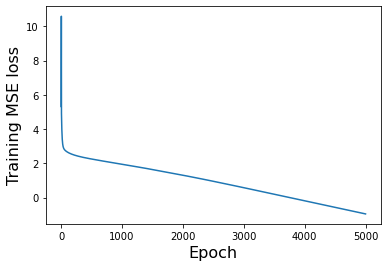

In [252]:
plt.plot(range(len(y_loss)),np.log(y_loss));plt.xlabel('Epoch',fontsize=16);plt.ylabel('Training MSE loss',fontsize=16);
plt.savefig('NTK loss complicated.pdf');plt.show()